# Generate Waterbirds Original, FG-Only and BG-Only data

In [2]:
import os
import numpy as np
import random
import pandas as pd
from PIL import Image
from tqdm import tqdm
from pycocotools.mask import encode, decode

import cv2

from detectron2.structures import BoxMode

import sys
sys.path.append("../group_DRO/")

# code from https://github.com/kohpangwei/group_DRO
from dataset_scripts.dataset_utils import crop_and_resize, combine_and_mask

Change the paths below.

In [34]:
cub_dir = '/datasets/datasets/CUB_200_2011/'
places_dir = '/datasets/places4waterbirds/'
output_dir = '/datasets/'
dataset_name = 'waterbirds_birds_places'

In [35]:
target_places = [
    ['bamboo_forest', 'forest/broadleaf'],  # Land backgrounds
    ['ocean', 'lake/natural']]              # Water backgrounds

val_frac = 0.2             # What fraction of the training data to use as validation
confounder_strength = 0.95 # Determines relative size of majority vs. minority groups

## Birds

In [36]:
images_path = os.path.join(cub_dir, 'images.txt')

df = pd.read_csv(
    images_path,
    sep=" ",
    header=None,
    names=['img_id', 'img_filename'],
    index_col='img_id')

In [37]:
### Set up labels of waterbirds vs. landbirds
# We consider water birds = seabirds and waterfowl.
species = np.unique([img_filename.split('/')[0].split('.')[1].lower() for img_filename in df['img_filename']])
water_birds_list = [
    'Albatross', # Seabirds
    'Auklet',
    'Cormorant',
    'Frigatebird',
    'Fulmar',
    'Gull',
    'Jaeger',
    'Kittiwake',
    'Pelican',
    'Puffin',
    'Tern',
    'Gadwall', # Waterfowl
    'Grebe',
    'Mallard',
    'Merganser',
    'Guillemot',
    'Pacific_Loon'
]


water_birds = {}
for species_name in species:
    water_birds[species_name] = 0
    for water_bird in water_birds_list:
        if water_bird.lower() in species_name:
            water_birds[species_name] = 1
species_list = [img_filename.split('/')[0].split('.')[1].lower() for img_filename in df['img_filename']]
df['y'] = [water_birds[species] for species in species_list]

In [38]:
train_test_df =  pd.read_csv(
    os.path.join(cub_dir, 'train_test_split.txt'),
    sep=" ",
    header=None,
    names=['img_id', 'split'],
    index_col='img_id')

In [39]:
df = df.join(train_test_df, on='img_id')
test_ids = df.loc[df['split'] == 0].index
train_ids = np.array(df.loc[df['split'] == 1].index)
val_ids = np.random.choice(
    train_ids,
    size=int(np.round(val_frac * len(train_ids))),
    replace=False)


In [40]:
df.loc[train_ids, 'split'] = 0
df.loc[val_ids, 'split'] = 1
df.loc[test_ids, 'split'] = 2

## Places

In [42]:
df['place'] = 0
train_ids = np.array(df.loc[df['split'] == 0].index)
val_ids = np.array(df.loc[df['split'] == 1].index)
test_ids = np.array(df.loc[df['split'] == 2].index)
for split_idx, ids in enumerate([train_ids, val_ids, test_ids]):
    for y in (0, 1):
        if split_idx == 0: # train
            if y == 0:
                pos_fraction = 1 - confounder_strength
            else:
                pos_fraction = confounder_strength
        else:
            pos_fraction = 0.5
        subset_df = df.loc[ids, :]
        y_ids = np.array((subset_df.loc[subset_df['y'] == y]).index)
        pos_place_ids = np.random.choice(
            y_ids,
            size=int(np.round(pos_fraction * len(y_ids))),
            replace=False)
        df.loc[pos_place_ids, 'place'] = 1


In [43]:
for split, split_label in [(0, 'train'), (1, 'val'), (2, 'test')]:
    print(f"{split_label}:")
    split_df = df.loc[df['split'] == split, :]
    print(f"waterbirds are {np.mean(split_df['y']):.3f} of the examples")
    print(f"y = 0, c = 0: {np.mean(split_df.loc[split_df['y'] == 0, 'place'] == 0):.3f}, n = {np.sum((split_df['y'] == 0) & (split_df['place'] == 0))}")
    print(f"y = 0, c = 1: {np.mean(split_df.loc[split_df['y'] == 0, 'place'] == 1):.3f}, n = {np.sum((split_df['y'] == 0) & (split_df['place'] == 1))}")
    print(f"y = 1, c = 0: {np.mean(split_df.loc[split_df['y'] == 1, 'place'] == 0):.3f}, n = {np.sum((split_df['y'] == 1) & (split_df['place'] == 0))}")
    print(f"y = 1, c = 1: {np.mean(split_df.loc[split_df['y'] == 1, 'place'] == 1):.3f}, n = {np.sum((split_df['y'] == 1) & (split_df['place'] == 1))}")

train:
waterbirds are 0.231 of the examples
y = 0, c = 0: 0.950, n = 3503
y = 0, c = 1: 0.050, n = 184
y = 1, c = 0: 0.050, n = 55
y = 1, c = 1: 0.950, n = 1053
val:
waterbirds are 0.226 of the examples
y = 0, c = 0: 0.500, n = 464
y = 0, c = 1: 0.500, n = 464
y = 1, c = 0: 0.498, n = 135
y = 1, c = 1: 0.502, n = 136
test:
waterbirds are 0.222 of the examples
y = 0, c = 0: 0.500, n = 2255
y = 0, c = 1: 0.500, n = 2255
y = 1, c = 0: 0.500, n = 642
y = 1, c = 1: 0.500, n = 642


In [44]:
place_ids_df = pd.read_csv(
    os.path.join(places_dir, 'categories_places365.txt'),
    sep=" ",
    header=None,
    names=['place_name', 'place_id'],
    index_col='place_id')

In [45]:
target_place_ids = []

for idx, target_places in enumerate(target_places):
    place_filenames = []

    for target_place in target_places:
        target_place_full = f'/{target_place[0]}/{target_place}'
        print(target_place, target_place_full)
        assert (np.sum(place_ids_df['place_name'] == target_place_full) == 1)
        target_place_ids.append(place_ids_df.index[place_ids_df['place_name'] == target_place_full][0])
        print(f'train category {idx} {target_place_full} has id {target_place_ids[idx]}')

        place_filenames += [
            f'/{target_place[0]}/{target_place}/{filename}' for filename in os.listdir(
                os.path.join(places_dir, target_place[0], target_place))
            if filename.endswith('.jpg')]

    random.shuffle(place_filenames)

    # Assign each filename to an image
    indices = (df.loc[:, 'place'] == idx)
    assert len(place_filenames) >= np.sum(indices),\
        f"Not enough places ({len(place_filenames)}) to fit the dataset ({np.sum(df.loc[:, 'place'] == idx)})"
    df.loc[indices, 'place_filename'] = place_filenames[:np.sum(indices)]

bamboo_forest /b/bamboo_forest
train category 0 /b/bamboo_forest has id 36
forest/broadleaf /f/forest/broadleaf
train category 0 /f/forest/broadleaf has id 36
ocean /o/ocean
train category 1 /o/ocean has id 150
lake/natural /l/lake/natural
train category 1 /l/lake/natural has id 150


## Construct Waterbirds

In [46]:
output_subfolder = os.path.join(output_dir, dataset_name)
os.makedirs(output_subfolder, exist_ok=True)

In [47]:
df.to_csv(os.path.join(output_subfolder, 'metadata.csv'))

In [48]:
def get_segmentation(mask):
    contours, hierarchy = cv2.findContours((mask[:, :, 0]).astype(np.uint8), cv2.RETR_TREE,
                                                        cv2.CHAIN_APPROX_SIMPLE)
    segmentation = []

    for contour in contours:
        contour = contour.flatten().tolist()
        # segmentation.append(contour)
        if len(contour) > 4:
            segmentation.append(contour)
    return segmentation

In [65]:
train_instances = []
test_instances = []
val_instances = []

for i in tqdm(df.index):
    # Load bird image and segmentation
    img_path = os.path.join(cub_dir, 'images', df.loc[i, 'img_filename'])
    seg_path = os.path.join(cub_dir, 'segmentations', df.loc[i, 'img_filename'].replace('.jpg','.png'))
    img_np = np.asarray(Image.open(img_path).convert('RGB'))
    seg_np = np.asarray(Image.open(seg_path).convert('RGB')) / 255


    place_path = os.path.join(places_dir, df.loc[i, 'place_filename'][1:])
    place = Image.open(place_path).convert('RGB')

    img_black = Image.fromarray(np.around(img_np * seg_np).astype(np.uint8))
    combined_img = combine_and_mask(place, seg_np, img_black)
    bird_img = combine_and_mask(Image.fromarray(np.ones_like(place) * 150), seg_np, img_black)
    
    seg_np *= 0.
    img_black = Image.fromarray(np.around(img_np * seg_np).astype(np.uint8))
    place_img = combine_and_mask(place, seg_np * 0, img_black)

    combined_path = os.path.join(output_subfolder, "combined", df.loc[i, 'img_filename'])
    bird_path = os.path.join(output_subfolder, "birds", df.loc[i, 'img_filename'])
    place_path = os.path.join(output_subfolder, "places", df.loc[i, 'img_filename'])
    
    os.makedirs('/'.join(combined_path.split('/')[:-1]), exist_ok=True)
    os.makedirs('/'.join(bird_path.split('/')[:-1]), exist_ok=True)
    os.makedirs('/'.join(place_path.split('/')[:-1]), exist_ok=True)

    combined_img.save(combined_path)
    bird_img.save(bird_path)
    place_img.save(place_path)

100%|██████████| 11788/11788 [12:32<00:00, 15.66it/s]


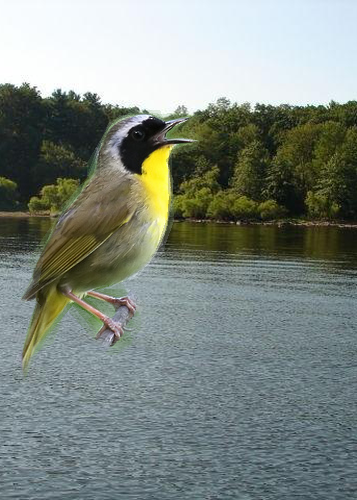

In [66]:
combined_img

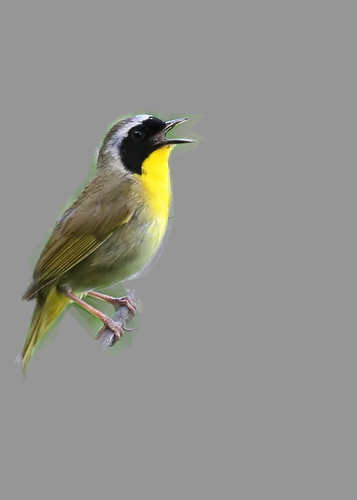

In [67]:
bird_img

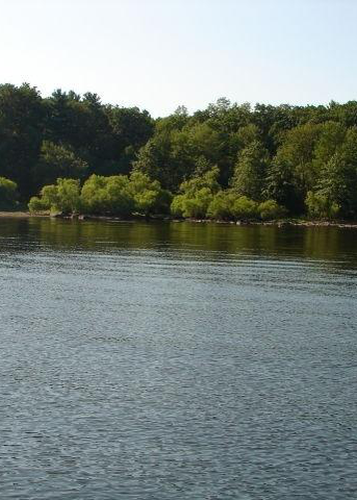

In [68]:
place_img